### Only relevant thing in this notebook is the power analysis figures all the way down the bottom of this notebook. The actual power analysis can be done using power_analysis.py 

In [1]:
%reload_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html

import torch
import numpy as np
from latent_statistics import permutation_test
from multiprocessing import Pool
import scanpy as sc
from scipy.stats import ks_2samp
import pandas as pd
import random
from dataprep import *
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)

custom = {"axes.edgecolor": "grey"}
sns.set_style("whitegrid")

In [16]:

custom = {"axes.edgecolor": "grey"}
sns.set_style("whitegrid")
plt.rcParams['grid.alpha'] = 0.4
sns.set_palette("colorblind")

# Like colorblind_palette[4] for control, colorblind_palette[0] for test

In [33]:
import sys
import os
kernel_name = os.path.basename(sys.executable.replace("/bin/python",""))
kernel_name

'blurry'

# Load data

In [ ]:
path = f"/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pattern.pkl"
with open(path, 'rb') as p:
    rf_pattern_balanced = pickle.load(p)

path = f"/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pattern_balanced_singlejob.pkl"
with open(path, 'rb') as p:
    rf_pattern_balanced_singlejob = pickle.load(p)

In [46]:
adata_split_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [47]:
def map_interval(interval):
    if interval == '0-10':
        return '0-10'
    elif interval in ['10-20', '20-30']:
        return '10-30'
    elif interval in ['30-40', '40-50', '50-60']:
        return '30-60'
    elif interval in ['70-80', '80-90', '90-100']:
        return '70-100'
    elif interval == '100+':
        return '100+'
    else:
        return None
    
def initialize_adata(adata):
    choices = ['strong', 'intermediate', 'low']
    conditions = [
        (adata.obs['prop'] == 0.9) | ((adata.obs['prop'] == 0.4) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.5) | ((adata.obs['prop'] == 0.2) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.1) | ((adata.obs['prop'] == 0.0) & (adata.obs['pattern'] == 'protrusion'))
    ]
    adata.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

    # Include modified RNA count intervals in the adata object
    adata.obs['rna_count'] = adata.obs['n_spots_interval'].apply(map_interval)


    return adata

In [48]:
adata_split_cellID = initialize_adata(adata_split_cellID)
adata_test = adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])]

In [37]:
for strength in adata_test.obs['pattern_strength'].unique():
    test = adata_test[(adata_test.obs['pattern_strength'] == strength) & (adata_test.obs['pattern'] != 'random')]
    print(strength)
    print(test.obs['rna_count'].value_counts())

strong
100+      40397
30-60     19812
70-100    19450
10-30     13590
0-10       3802
Name: rna_count, dtype: int64
intermediate
100+      39604
30-60     20502
70-100    19760
10-30     12987
0-10       4206
Name: rna_count, dtype: int64
low
100+      39734
70-100    20247
30-60     19896
10-30     13264
0-10       3900
Name: rna_count, dtype: int64


In [60]:
test = adata_test[(adata_test.obs['pattern'] == 'random')]
print(test.obs['rna_count'].value_counts())

100+      16213
30-60      7836
70-100     7402
10-30      5305
0-10       1442
Name: rna_count, dtype: int64


In [62]:
strength = 'strong'
count = '10-30'
sample = 5

pattern = subset_power_analysis(adata_test, mixed_patterns = True, pattern_strength= strength, rna_count = count, sample_size = sample)
control = subset_power_analysis(adata_test, pattern = 'random', mixed_patterns = False, rna_count = count, sample_size = sample)

p_value, observed_statistic, permuted_statistics = permutation_test(
    pattern.obsm['latent'], 
    control.obsm['latent'], 
    n_permutations=9999)

print(f"Observed chamfer distance: {observed_statistic}")
print(f"P-value: {p_value}")

Observed chamfer distance: 115.97711181640625
P-value: 0.01984126984126984


# Functions

In [63]:
def subset_power_analysis(adata, pattern: str = 'pericellular', mixed_patterns: bool = True, pattern_strength: str = "strong", rna_count: str = '10-30', sample_size: int = 5):
    """
    Subset the anndata object into a `1 gene multiple cells` object. Can filter the cells based on the number of spots, the pattern and the pattern strength.

    Parameters
    ----------
    adata : ad.AnnData object
        complete anndata object.
    pattern : str
        Type of subcellular expression pattern you want to filter on. Default is 'pericellular', which has the highest f1 RF score.
    mixed_patterns: bool
        True: all patterns can be included, False: only the pattern type specified in `pattern` is included. Default is False. 
    pattern_strength : str
        strength of the pattern, which is labeled as pattern_strength in the anndata object. Strong, which comes down to 45% of points fall in the pattern for protrusion, 90% of points are in pattern for all the other patterns. 
        If the pattern is random, then pattern_strength is not used, given that irrelevant for random when using the simFISH v2 definition of patterness (90% of points assigned to the pattern 'random' will still amount to 100% randomness).
    high_or_low : str
        Whether you want to filter genes with a higher or lower count than the given threshold. Default is lower.
        If none, then no threshold is chosen and mixed counts are included. 
    count_threshold : int
        Count threshold to filter on. Default is 11, so that genes with count 0-10 are selected. For high, the threshold is 140.
    mixed_counts: bool
        True: all counts are included, False: only counts above or below the threshold are included. Default is False.
        
    Returns
    -------
    ad.AnnData

    """
    adata_filtered = adata[(
                                (
                                    adata.obs['pattern'] == pattern if mixed_patterns == False
                                    else adata.obs['pattern'] != 'random'
                                )
                            ) & 
                           (
                                adata.obs['rna_count'] == rna_count
                            ) & 
                           (
                               adata.obs['pattern_strength'] == pattern_strength if pattern != 'random' 
                               else True
                            )
                        ].copy()

    subset = adata_filtered.obs.sample(n=sample_size) # , replace=True  --> old graphs
    
    adata_subset = adata_filtered[adata_filtered.obs.index.isin(subset.index)]


    return adata_subset

Add bins to pool the power calculation for n_spots_interval

In [265]:
def compute_power_rf(params):
    try:
        strength, count, sample = params
        significant_count = 0
        # Given that random patterns have only 1442 cells simulated, we don't calculate the power for these above 1400 so that we don't need to sample with replacement
        if count == '0-10' and sample > 1400:
            return (f'{strength}_{count}_{sample}', -1)
        if count == '10-30' and sample > 5100:
            return (f'{strength}_{count}_{sample}', -1)
        for i in range(1000):
            # sample new gene. No random seed so that every time a different "gene" is sampled.
            pattern = subset_power_analysis(adata_test, mixed_patterns = True, pattern_strength= strength, rna_count = count, sample_size = sample)
            control = subset_power_analysis(adata_test, pattern = 'random', mixed_patterns = False, rna_count = count, sample_size = sample)

            # Calculate RF classification probabilities
            pattern_score = rf_pattern_balanced_singlejob.predict_proba(pattern.obsm["latent"])[:,1]
            control_score = rf_pattern_balanced_singlejob.predict_proba(control.obsm["latent"])[:,1]

            statistic, pvalue = ks_2samp(pattern_score, control_score)
            critical_value = 0.05
            if pvalue < critical_value:
                significant_count += 1
        return (f'{strength}_{count}_{sample}', significant_count/1000)
    except ValueError as e:
        if str(e) == "Cannot take a larger sample than population when 'replace=False'":
            print(f"Error for parameters: {params}")
            return None
        else:
            raise e

In [64]:
def compute_power_permutation(params):
    try:
        strength, count, sample = params
        significant_count = 0
        # Given that random patterns have only 1442 cells simulated, we don't calculate the power for these above 1400 so that we don't need to sample with replacement
        if count == '0-10' and sample > 1400:
            return (f'{strength}_{count}_{sample}', -1)
        if count == '10-30' and sample > 5100:
            return (f'{strength}_{count}_{sample}', -1)
        for i in range(1000):
            # sample new gene. No random seed so that every time a different "gene" is sampled.
            pattern = subset_power_analysis(adata_test, mixed_patterns = True, pattern_strength= strength, rna_count = count, sample_size = sample)
            control = subset_power_analysis(adata_test, pattern = 'random', mixed_patterns = False, rna_count = count, sample_size = sample)

            # Calculate null distribution and pvalue
            pvalue, observed_statistic, permuted_statistics = permutation_test(pattern.obsm["latent"], control.obsm["latent"], n_permutations=9999)
            
            critical_value = 0.05
            if pvalue < critical_value:
                significant_count += 1
        return (f'{strength}_{count}_{sample}', significant_count/1000)
    except ValueError as e:
        if str(e) == "Cannot take a larger sample than population when 'replace=False'":
            print(f"Error for parameters: {params}")
            return None
        else:
            raise e

# Power analysis

In [65]:
import numpy as np

# Generate 10 points between 5 and 3000 on a log scale
points = np.logspace(np.log10(5), np.log10(7000), num=14)

# Round the points to the nearest integers
points = np.round(points).astype(int)

print(points)

# Generate 10 points between 5 and 3000 on a log scale
points = np.logspace(np.log10(10), np.log10(7000), num=14)

# Round the points to the nearest integers
points = np.round(points).astype(int)

print(points)

[   5    9   15   27   46   81  142  247  432  753 1315 2297 4009 7000]
[  10   17   27   45   75  124  206  340  563  933 1544 2555 4229 7000]


In [ ]:
# 10 rounded points between 5 and 5000 on a log10 scale
[5, 11, 23, 50, 108, 232, 500, 1077, 2321, 5000]


# 14 rounded points between 5 and 7000 on a log10 scale
[5, 9, 15, 27, 46, 81, 142, 247, 432, 753, 1315, 2297, 4009, 7000]


# 15 equaly spaced points between 5 and 7000
[5, 504, 1004, 1503, 2003, 2503, 3002, 3502, 4002, 4501, 5001, 5501, 6000, 6500, 7000]

In [ ]:
import multiprocessing as mp

strengths = ['strong', 'intermediate', 'low']
counts = adata_test.obs['rna_count'].unique()
samples = [5, 9, 15, 27, 46, 81, 142, 247, 432, 753, 1315, 2297, 4009, 7000]

# Create a list of all combinations of strength, count, and sample
combinations = [(strength, count, sample) for strength in strengths for count in counts for sample in samples]

# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)

# Create a multiprocessing pool and compute the power for each combination
with Pool(45) as p:
    results = p.map(compute_power_permutation, combinations)

# Convert the results to a dictionary
power_results = dict(results)

### Safe and load power analysis dictionary

In [ ]:
path = f"temp_objects/power_analysis_permutationLatent_to7000_logscale_uncorrected.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(power_results, f)

In [249]:
path = "/media/gambino/students_workdir/nynke/blurry/temp_objects/power_analysis_allStrength_withoutReplacement_to5000_fixedDefaultPattern.pkl"

with open(path, 'rb') as p:
    power_results = pickle.load(p)

### Visualizations

In [8]:
df = pd.read_csv('results.txt', sep='\t', names=['strength', 'rna_count', 'sample_size', 'power'])
df['strength'].unique()

array(['strong', 'intermediate', 'low', 'low 10-30   753 0.867'],
      dtype=object)

In [9]:
df = df[df['strength']!='low 10-30   753 0.867']
df['strength'].unique()

array(['strong', 'intermediate', 'low'], dtype=object)

In [10]:
df

,strength,rna_count,sample_size,power
0,strong,10-30,5.0,0.478
1,strong,100+,5.0,0.933
2,strong,100+,5.0,0.933
3,strong,0-10,5.0,0.200
4,intermediate,0-10,5.0,0.067
...,...,...,...,...
163,intermediate,100+,1315.0,1.000
164,intermediate,0-10,1315.0,1.000
165,intermediate,10-30,1315.0,1.000
166,intermediate,30-60,1315.0,1.000


In [12]:
new_row = pd.DataFrame({'strength': ['low'], 'rna_count': ['10-30'], 'sample_size': [753], 'power': [0.867]})
df = pd.concat([df, new_row], ignore_index=True)
df

,strength,rna_count,sample_size,power
0,strong,10-30,5.0,0.478
1,strong,100+,5.0,0.933
2,strong,100+,5.0,0.933
3,strong,0-10,5.0,0.200
4,intermediate,0-10,5.0,0.067
...,...,...,...,...
163,intermediate,0-10,1315.0,1.000
164,intermediate,10-30,1315.0,1.000
165,intermediate,30-60,1315.0,1.000
166,intermediate,70-100,1315.0,1.000


In [ ]:
# Convert the dictionary to a list of tuples
data = [(strength, rna_count, sample_size, power) for key, power in power_results.items() for strength, rna_count, sample_size in [key.split('_')]]

# Convert the list of tuples to a DataFrame
df = pd.DataFrame(data, columns=["strength", "rna_count", "sample_size", "power"])

In [13]:
# Replace values in the 'strength' column --> so I can have a capital in my plot titles
df['strength'] = df['strength'].replace({'strong': 'Strong', 'intermediate': 'Intermediate', 'low': 'Low'})

In [ ]:
df = pd.read_csv('results.txt', sep='\t', names=['strength', 'rna_count', 'sample_size', 'power'])
df = df[df['power'] != -1]

In [29]:
df['sample_size'] = df['sample_size'].astype(int)
df['sample_size']

0         5
1         5
2         5
3         5
4         5
       ... 
163    1315
164    1315
165    1315
166    1315
167     753
Name: sample_size, Length: 168, dtype: int64

In [27]:
test = df[df['strength']=='Low']
test[test['rna_count']=='100+']

,strength,rna_count,sample_size,power
47,Low,100+,5.0,0.058
52,Low,100+,15.0,0.072
53,Low,100+,9.0,0.056
57,Low,100+,46.0,0.089
69,Low,100+,27.0,0.078
93,Low,100+,81.0,0.092
101,Low,100+,142.0,0.119
120,Low,100+,247.0,0.179
132,Low,100+,432.0,0.273
146,Low,100+,753.0,0.488


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/media/gambino/st

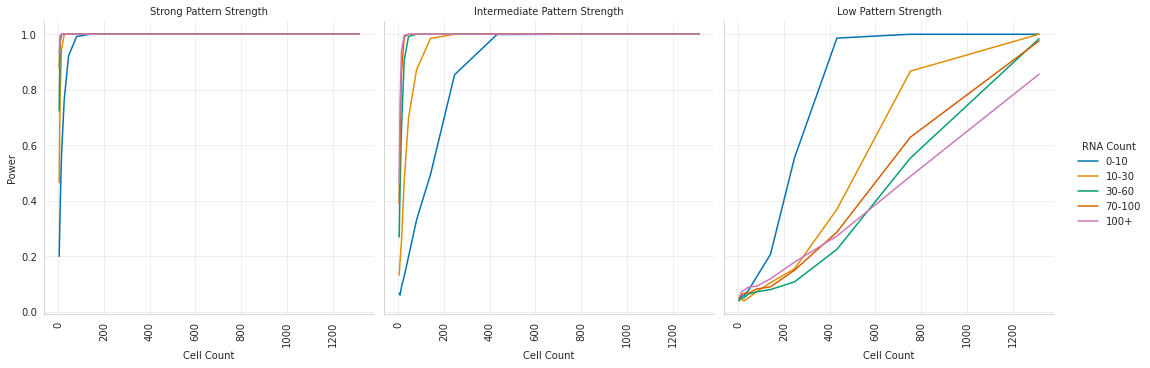

In [30]:
# Create three plots with different pattern strengths
g = sns.relplot(
    data=df, 
    x="sample_size", 
    y="power", 
    hue="rna_count",
    hue_order = ['0-10', '10-30', '30-60', '70-100','100+'],
    palette="colorblind",
    col="strength",
    kind="line")
(g
  .set_axis_labels("Cell Count", "Power")
  .set_titles("{col_name} Pattern Strength")
  .tight_layout(w_pad=1)
  .legend.set_title("RNA Count"))

# Rotate x-axis labels for each subplot
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
# Show the plot
plt.show()

<ipython-input-271-e557b7426502>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
<ipython-input-271-e557b7426502>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
<ipython-input-271-e557b7426502>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


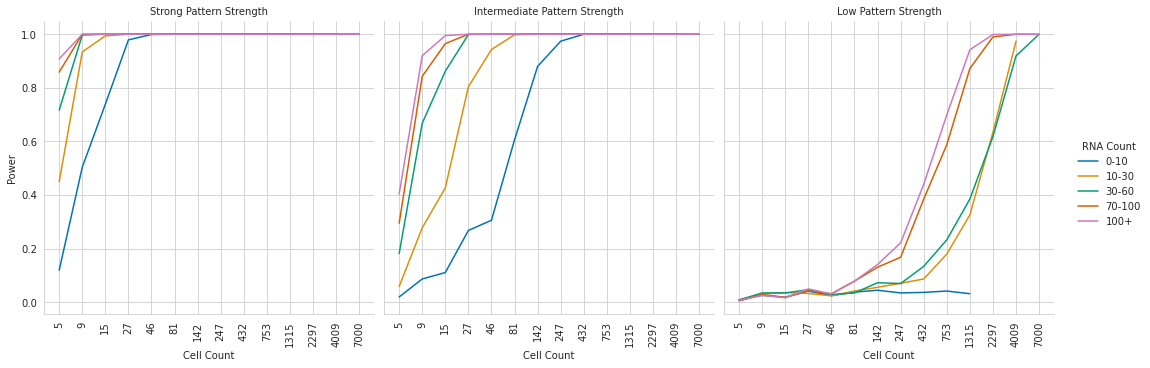

In [271]:
# Create three plots with different pattern strengths
g = sns.relplot(
    data=df, 
    x="sample_size", 
    y="power", 
    hue="rna_count",
    hue_order = ['0-10', '10-30', '30-60', '70-100','100+'],
    palette="colorblind",
    col="strength",
    kind="line")
(g
  .set_axis_labels("Cell Count", "Power")
  .set_titles("{col_name} Pattern Strength")
  .tight_layout(w_pad=1)
  .legend.set_title("RNA Count"))

# Rotate x-axis labels for each subplot
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
# Show the plot
plt.show()